# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


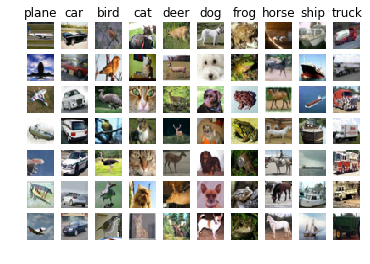

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


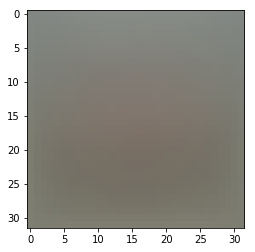

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.648061


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.659384 analytic: 4.659384, relative error: 5.336066e-12
numerical: -11.821389 analytic: -11.821389, relative error: 2.658197e-11
numerical: 5.751513 analytic: 5.751513, relative error: 1.653685e-11
numerical: 26.573675 analytic: 26.573675, relative error: 5.573460e-12
numerical: 22.544236 analytic: 22.544236, relative error: 1.847994e-11
numerical: 24.105266 analytic: 24.105266, relative error: 3.004792e-11
numerical: -16.736688 analytic: -16.750966, relative error: 4.263696e-04
numerical: -11.607231 analytic: -11.607231, relative error: 4.995952e-13
numerical: 13.726470 analytic: 13.742061, relative error: 5.675747e-04
numerical: -25.366234 analytic: -25.360661, relative error: 1.098583e-04
numerical: -8.712393 analytic: -8.712393, relative error: 3.155705e-11
numerical: 17.531980 analytic: 17.531980, relative error: 4.013120e-12
numerical: 5.094695 analytic: 5.094695, relative error: 7.167593e-11
numerical: 6.645789 analytic: 6.645789, relative error: 3.381025e-12
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:**
Basically if the loss function is differentiable, the relative error should be very small. But for SVM, the gradcheck may not match as the predicted class score is on the margin border (where the loss function is not continuous). This is usually not an issue for training SVM with SGD.

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.648061e+00 computed in 0.100388s
Vectorized loss: 9.648061e+00 computed in 0.044463s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.091895s
Vectorized loss and gradient: computed in 0.011940s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 790.487407
iteration 100 / 1500: loss 289.894868
iteration 200 / 1500: loss 109.148987
iteration 300 / 1500: loss 43.239974
iteration 400 / 1500: loss 19.517257
iteration 500 / 1500: loss 10.624196
iteration 600 / 1500: loss 7.194156
iteration 700 / 1500: loss 6.467962
iteration 800 / 1500: loss 5.686838
iteration 900 / 1500: loss 5.534532
iteration 1000 / 1500: loss 5.968446
iteration 1100 / 1500: loss 5.037745
iteration 1200 / 1500: loss 5.203980
iteration 1300 / 1500: loss 5.751571
iteration 1400 / 1500: loss 5.435059
That took 8.244661s


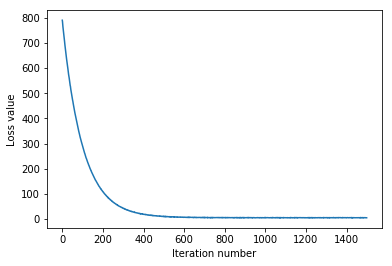

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
losses = loss_hist
plt.plot(losses)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

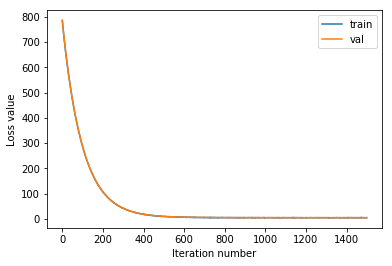

In [16]:
# plot the loss as a function of iteration number:
# (with val_loss, trained with validation_data argument)
losses, val_losses = zip(*loss_hist)
plt.plot(losses)
plt.plot(val_losses)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.376633
validation accuracy: 0.379000


In [17]:
# Experiment 1
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-6, 1e-5, 1e-4]
regularization_strengths = [1e3, 1e4, 1e5]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        trn_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (trn_acc, val_acc)
        if val_acc > best_val:
            best_val, best_svm = val_acc, svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 50.912727
iteration 100 / 1500: loss 26.402681
iteration 200 / 1500: loss 19.997369
iteration 300 / 1500: loss 13.248686
iteration 400 / 1500: loss 10.961867
iteration 500 / 1500: loss 8.199817
iteration 600 / 1500: loss 8.036153
iteration 700 / 1500: loss 7.173788
iteration 800 / 1500: loss 6.672386
iteration 900 / 1500: loss 6.282048
iteration 1000 / 1500: loss 5.331165
iteration 1100 / 1500: loss 5.711459
iteration 1200 / 1500: loss 4.510648
iteration 1300 / 1500: loss 5.608031
iteration 1400 / 1500: loss 5.055658
iteration 0 / 1500: loss 327.800581
iteration 100 / 1500: loss 11.047805
iteration 200 / 1500: loss 6.629234
iteration 300 / 1500: loss 5.668091
iteration 400 / 1500: loss 5.850980
iteration 500 / 1500: loss 5.925003
iteration 600 / 1500: loss 6.085888
iteration 700 / 1500: loss 7.083849
iteration 800 / 1500: loss 6.171706
iteration 900 / 1500: loss 6.098476
iteration 1000 / 1500: loss 5.478057
iteration 1100 / 1500: loss 6.339854
iteration 1200 / 

/home/radream/assignment1/cs231n/classifiers/linear_svm.py:106: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
/home/shared/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/radream/assignment1/cs231n/classifiers/linear_svm.py:106: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 200 / 1500: loss inf


/home/radream/assignment1/cs231n/classifiers/linear_svm.py:107: RuntimeWarning: overflow encountered in multiply
  dW += 2*reg*W
/home/radream/assignment1/cs231n/classifiers/linear_svm.py:98: RuntimeWarning: invalid value encountered in greater
  coef_grad = (margins > 0).astype('int32')
/home/radream/assignment1/cs231n/classifiers/linear_classifier.py:82: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


iteration 300 / 1500: loss nan
iteration 400 / 1500: loss nan
iteration 500 / 1500: loss nan
iteration 600 / 1500: loss nan
iteration 700 / 1500: loss nan
iteration 800 / 1500: loss nan
iteration 900 / 1500: loss nan
iteration 1000 / 1500: loss nan
iteration 1100 / 1500: loss nan
iteration 1200 / 1500: loss nan
iteration 1300 / 1500: loss nan
iteration 1400 / 1500: loss nan
lr 1.000000e-06 reg 1.000000e+03 train accuracy: 0.369592 val accuracy: 0.375000
lr 1.000000e-06 reg 1.000000e+04 train accuracy: 0.302041 val accuracy: 0.291000
lr 1.000000e-06 reg 1.000000e+05 train accuracy: 0.286000 val accuracy: 0.308000
lr 1.000000e-05 reg 1.000000e+03 train accuracy: 0.223367 val accuracy: 0.243000
lr 1.000000e-05 reg 1.000000e+04 train accuracy: 0.170408 val accuracy: 0.163000
lr 1.000000e-05 reg 1.000000e+05 train accuracy: 0.114510 val accuracy: 0.112000
lr 1.000000e-04 reg 1.000000e+03 train accuracy: 0.180837 val accuracy: 0.173000
lr 1.000000e-04 reg 1.000000e+04 train accuracy: 0.07261

In [23]:
# Experiment 2
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 4e-7]
regularization_strengths = [1e3, 2.5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=2000, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        trn_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (trn_acc, val_acc)
        if val_acc > best_val:
            best_val, best_svm = val_acc, svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 49.031572
iteration 100 / 2000: loss 39.484675
iteration 200 / 2000: loss 36.170406
iteration 300 / 2000: loss 35.739903
iteration 400 / 2000: loss 32.917869
iteration 500 / 2000: loss 32.916078
iteration 600 / 2000: loss 30.776617
iteration 700 / 2000: loss 28.864367
iteration 800 / 2000: loss 28.419906
iteration 900 / 2000: loss 27.670314
iteration 1000 / 2000: loss 26.043357
iteration 1100 / 2000: loss 25.762778
iteration 1200 / 2000: loss 23.855630
iteration 1300 / 2000: loss 23.567006
iteration 1400 / 2000: loss 21.806386
iteration 1500 / 2000: loss 21.942327
iteration 1600 / 2000: loss 20.657827
iteration 1700 / 2000: loss 20.192745
iteration 1800 / 2000: loss 19.533770
iteration 1900 / 2000: loss 19.126518
iteration 0 / 2000: loss 804.553396
iteration 100 / 2000: loss 290.570870
iteration 200 / 2000: loss 109.136767
iteration 300 / 2000: loss 42.873602
iteration 400 / 2000: loss 19.303452
iteration 500 / 2000: loss 9.703773
iteration 600 / 2000: loss 7.6

In [26]:
# Experiment 3
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [2e-7, 3e-7, 4e-7]
regularization_strengths = [5e2, 1e3, 2.5e3, 1e4, 2.5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=2000, verbose=True)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        trn_acc = np.mean(y_train == y_train_pred)
        val_acc = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (trn_acc, val_acc)
        if val_acc > best_val:
            best_val, best_svm = val_acc, svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 34.461132
iteration 100 / 2000: loss 25.723858
iteration 200 / 2000: loss 23.506345
iteration 300 / 2000: loss 21.231980
iteration 400 / 2000: loss 19.315096
iteration 500 / 2000: loss 18.972149
iteration 600 / 2000: loss 18.305006
iteration 700 / 2000: loss 17.106886
iteration 800 / 2000: loss 16.785932
iteration 900 / 2000: loss 15.487875
iteration 1000 / 2000: loss 15.470523
iteration 1100 / 2000: loss 14.102118
iteration 1200 / 2000: loss 14.593006
iteration 1300 / 2000: loss 14.537928
iteration 1400 / 2000: loss 13.569568
iteration 1500 / 2000: loss 12.885125
iteration 1600 / 2000: loss 12.353838
iteration 1700 / 2000: loss 11.914389
iteration 1800 / 2000: loss 12.006293
iteration 1900 / 2000: loss 12.066097
iteration 0 / 2000: loss 52.219953
iteration 100 / 2000: loss 37.494953
iteration 200 / 2000: loss 34.769386
iteration 300 / 2000: loss 31.059784
iteration 400 / 2000: loss 28.874104
iteration 500 / 2000: loss 26.263365
iteration 600 / 2000: loss 24.95

iteration 200 / 2000: loss 28.534268
iteration 300 / 2000: loss 24.611165
iteration 400 / 2000: loss 20.352085
iteration 500 / 2000: loss 18.938388
iteration 600 / 2000: loss 16.916000
iteration 700 / 2000: loss 14.536637
iteration 800 / 2000: loss 12.270864
iteration 900 / 2000: loss 11.060721
iteration 1000 / 2000: loss 10.958603
iteration 1100 / 2000: loss 9.829026
iteration 1200 / 2000: loss 8.769957
iteration 1300 / 2000: loss 8.024551
iteration 1400 / 2000: loss 6.843440
iteration 1500 / 2000: loss 7.001742
iteration 1600 / 2000: loss 6.686818
iteration 1700 / 2000: loss 6.163812
iteration 1800 / 2000: loss 6.451058
iteration 1900 / 2000: loss 6.182526
iteration 0 / 2000: loss 102.052780
iteration 100 / 2000: loss 57.435664
iteration 200 / 2000: loss 39.267666
iteration 300 / 2000: loss 27.768713
iteration 400 / 2000: loss 19.673710
iteration 500 / 2000: loss 15.378511
iteration 600 / 2000: loss 11.589948
iteration 700 / 2000: loss 9.031776
iteration 800 / 2000: loss 8.349972
ite

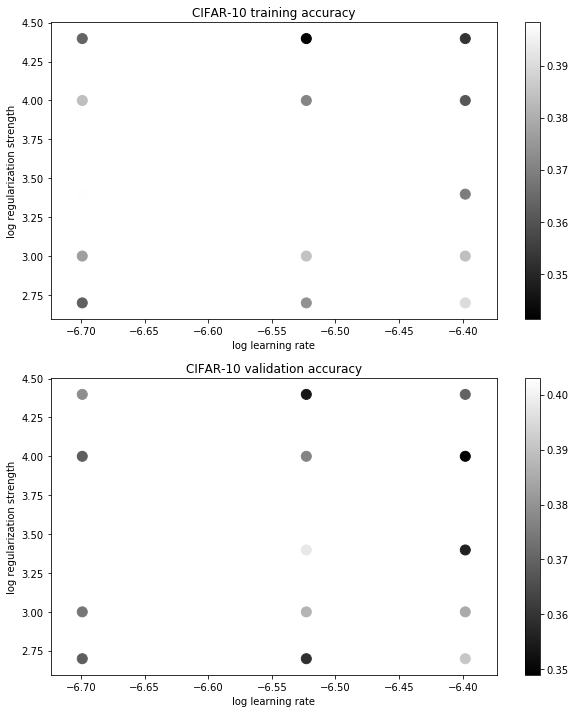

In [32]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.figure(figsize=(10,12))
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [33]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.374000


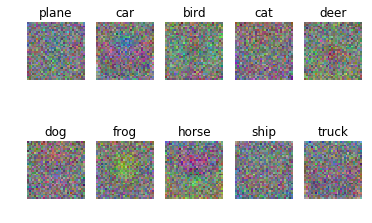

In [34]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way that they do.

**Your answer:**
The SVM weights are not that visually structured (look much noisy) as in softmax regression due to its hinge loss nature. The difference is that SVM wants WX score to satisfy the margin threshold but softmax wants WX to describe the probability of classes the input belonging to. Hence the weight in softmax would be more visually structured.